In [43]:
#拡張機能のインポート
import numpy as np
import matplotlib.pyplot as plt

N=50 #データ数
D = 3 #データの次元数
nodes = 10 #潜在空間の一次元あたりのノード数？
L = 2 #潜在空間の次元数
K = nodes**L #潜在空間のノード数
T = 100 #総学習回数 ここは変えて良いのかな?
tau = 50

seed = 10
np.random.seed(seed)


In [44]:
def gen_kura_data(num):
    #num = params.num_samples
    np.random.seed(0)
    z1 = np.random.uniform(low=-1, high=+1, size=(num))
    z2 = np.random.uniform(low=-1, high=+1, size=(num))

    X = np.empty(shape=(num, 3))
    X[:, 0] = z1
    X[:, 1] = z2
    X[:, 2] = 0.5 * (z1**2 - z2**2)
    return X

In [45]:
X = gen_kura_data(N)
print(X.shape)

(50, 3)


In [46]:
#潜在変数を乱数によって初期化
Z = np.random.rand(N,L)
Z.shape

(50, 2)

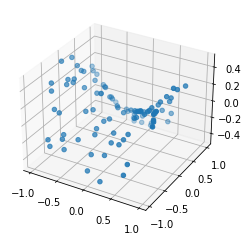

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') #三次元マップの描画
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

In [47]:
#ノードが存在する範囲？の設定 テクニックドリルを参照（詳しくは）
A = np.linspace(-1,1,nodes)
B = np.linspace(-1,1,nodes)
XX, YY = np.meshgrid(A,B)
xx = XX.reshape(-1)
yy = YY.reshape(-1)
M = np.concatenate([xx[:, None], yy[:, None]], axis=1) #変数表でいうζkに該当する
M.shape


(100, 2)

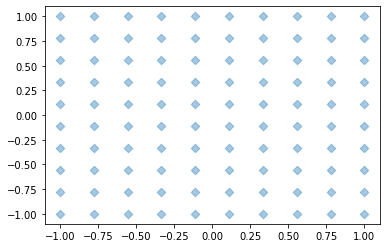

In [48]:
plt.scatter(M[:, 0], M[:, 1], alpha=0.4, marker='D')

In [56]:
#データの距離
def distance_function(A,B):
    distance= np.sum((A[:, None, :]-B[None, :, :])**2, axis=2)
    return distance
D = distance_function(M,Z)
D.shape

(100, 50)

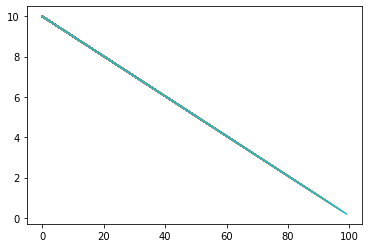

In [66]:
#近傍半径を減少させるスケージュリーングの設定、ς関数の描画
sigma_max = 10
sigma_min = 0.1
Sigma_t = []
times = []
def Reference_vector(t,Z,M,X):
    #パワーポイントの式を参照
    sigma = ((sigma_min-sigma_max)/T)*t+sigma_max
    #R_knの式
    R_kn = np.exp((-1/(2*sigma**2))*distance_function(M,Z))
    #print(R_kn.shape)
    #g_kの式 K次元のベクトル このオプションで潰れるのを防ぐ
    g_k = np.sum(R_kn, axis=1,keepdims=True)
    #print(g_k.shape)
    #y_kの式 エラー出る、ヒント：行列積、シェイプを意識しよう
    H = R_kn/g_k
    Y = H @ X
    #print(Y.shape)
    #y_k = (1/g_k)*np.sum()
    #print(sigma)
    return sigma,Y

for t in range(T):
    #sigma = sigma_max-(sigma_max-sigma_min)*(t/T)
    #print("t=",t+1,"sigma=",sigma)
    S_k,Y_k = Reference_vector(t,Z,M,X)
    Sigma_t.append(S_k)
    times.append(t)
    plt.plot(times,Sigma_t);

In [51]:
#-----------以下はpythonでの動作確認のためのテストコード---------------

In [52]:
list = [1, 2, 5, 9]
print (list)

[1, 2, 5, 9]


In [53]:
mylist = ["A", "B", "C"]
mylist.append("D")

print(mylist)

['A', 'B', 'C', 'D']


In [54]:
l_empty = []
print(l_empty)
# []

print(len(l_empty))
# 0

[]
0
